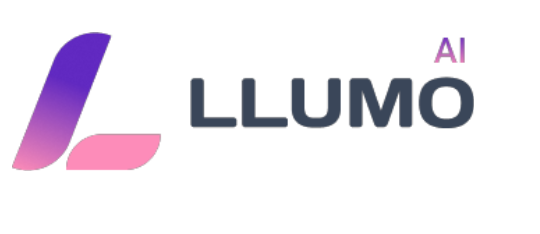

In [3]:
from IPython.display import Image
Image("/kaggle/input/lluma-image/Screenshot 2024-10-22 at 9.48.35 AM.png")

# Automatic Summarization of Meta Review Data Using Fine-Tuned Large Language Models (LLMs)

# Description of the Dataset:
The dataset used for this project consists of meta-reviews of academic papers paired with their corresponding summaries. Meta-reviews are detailed evaluations provided by expert reviewers, which synthesize feedback and critiques from multiple peer reviewers. The goal is to automatically generate concise, informative summaries of these meta-reviews using a fine-tuned GenAI LLM (large language model).

We will use the publicly available Meta-Review Dataset from Hugging Face:

Link to dataset:https://huggingface.co/datasets/zqz979/meta-review

Data structure: The dataset consists of pairs of text fields:
Input: The meta-review text.
Output: The human-written summary of the meta-review.

# Goal of the Project:
The main objective of this project is to fine-tune a pre-trained language model (LLM) to automatically summarize meta-review data. The project involves the following key steps:
1. Data Preprocessing: Clean and prepare the meta-review dataset for fine-tuning, including text normalization and formatting.
2. Fine-Tuning a Pre-trained LLM: Use a pre-trained GenAI model (such as T5, Pegasus, or BART) and fine-tune it on the meta-review dataset for summarization tasks. The model will be optimized to generate high-quality summaries.
3. Prompt Engineering: Design effective prompts that instruct the fine-tuned model to summarize meta-reviews effectively.
4. Evaluation: Measure the performance of the model using standard evaluation metrics like ROUGE (Recall-Oriented Understudy for Gisting Evaluation).
5. Enhancements (Bonus): Implement further functionalities like preprocessing the generated summaries to match specific criteria, and experimenting with different summarization techniques.

# Libraries Used
1. transformers: For loading pre-trained models and tokenizers, and fine-tuning the model on custom datasets.
2. datasets: For loading and managing the meta-review dataset, as well as any necessary preprocessing.
3. evaluate: For computing evaluation metrics such as ROUGE to assess the quality of the generated summaries.
4. torch: For fine-tuning the model, handling model training processes, and utilizing GPU acceleration. 

# Import necessary libraries

In [3]:
import torch
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from rouge_score import rouge_scorer

# Create a custom Dataset class to load CSV files

In [9]:
class TextSummaryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_input_length=512, max_output_length=150):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        input_text = "summarize: " + str(self.dataframe.iloc[index, 0])  
        target_text = str(self.dataframe.iloc[index, 1])  
        
        inputs = self.tokenizer(input_text, max_length=self.max_input_length, padding="max_length", truncation=True, return_tensors="pt")
        with self.tokenizer.as_target_tokenizer():
            targets = self.tokenizer(target_text, max_length=self.max_output_length, padding="max_length", truncation=True, return_tensors="pt")
        
        input_ids = inputs['input_ids'].squeeze()  
        attention_mask = inputs['attention_mask'].squeeze()
        labels = targets['input_ids'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


# Load the dataset of train, validation, and test

In [11]:
train_df = pd.read_csv('/kaggle/input/llumo-raw/RAW/train.csv')
valid_df = pd.read_csv('/kaggle/input/llumo-raw/RAW/validation.csv')
test_df = pd.read_csv('/kaggle/input/llumo-raw/RAW/test.csv')

# Load the T5-Base tokenizer and model

In [12]:
model_name = "t5-base" 
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Create DataLoader instances for training, validation, and testing

In [13]:
train_dataset = TextSummaryDataset(train_df, tokenizer)
valid_dataset = TextSummaryDataset(valid_df, tokenizer)
test_dataset = TextSummaryDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Set up the optimizer and scheduler

In [14]:
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Fine-tune the model

In [15]:
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        
        loss = outputs.loss`
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs} completed. Average Loss: {avg_loss}")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch 1/3 completed. Average Loss: 2.7009548159498187
Epoch 2/3 completed. Average Loss: 2.430431965111199
Epoch 3/3 completed. Average Loss: 2.3401295614589523


# Save the fine-tuned model, tokenizer, and optimizer

In [16]:
model.save_pretrained('./t5_summarization')
tokenizer.save_pretrained('./t5_summarization')
torch.save(optimizer.state_dict(), './t5_summarization/optimizer.pt')

#  Evaluation using ROUGE score on validation set

In [17]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

model.eval()
predictions = []
references = []
for batch in valid_dataloader:
    inputs = {k: v.to(device) for k, v in batch.items()}
    input_texts = tokenizer.batch_decode(inputs['input_ids'], skip_special_tokens=True)
    
    # Add the summarization prompt to each input text
    prompted_input_texts = [f"Summarize the following paper meta-review: {text}" for text in input_texts]
    
    # Tokenize the prompted input texts
    prompted_inputs = tokenizer(prompted_input_texts, max_length=512, padding="max_length", truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=150)
    
    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(inputs['labels'], skip_special_tokens=True)
    
    predictions.extend(decoded_preds)
    references.extend(decoded_labels)


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


# Calculate ROUGE score manually using rouge_scorer

In [18]:
rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
for pred, ref in zip(predictions, references):
    score = scorer.score(ref, pred)
    rouge_scores["rouge1"].append(score["rouge1"].fmeasure)
    rouge_scores["rouge2"].append(score["rouge2"].fmeasure)
    rouge_scores["rougeL"].append(score["rougeL"].fmeasure)

avg_rouge1 = sum(rouge_scores["rouge1"]) / len(rouge_scores["rouge1"])
avg_rouge2 = sum(rouge_scores["rouge2"]) / len(rouge_scores["rouge2"])
avg_rougeL = sum(rouge_scores["rougeL"]) / len(rouge_scores["rougeL"])

print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 Score: {avg_rouge2}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

Average ROUGE-1 Score: 0.3391844504586795
Average ROUGE-2 Score: 0.09055228559237102
Average ROUGE-L Score: 0.21821025331538807


# Result
1. The ROUGE-1 score (33.9%) is decent, showing that the model is reasonably good at capturing individual words that appear in the human-written summaries. This means the model can generally understand and pick out important keywords from the meta-reviews.
2. The ROUGE-2 score (9.1%) this implies that the generated summaries might be as coherent or precise in conveying the main ideas.
3. The ROUGE-L score (21.8%) indicates that the model capture the structure or order of the human-written summaries well, leading to accurate and well-ordered summaries.

# Compare to other projects
In comparison to other projects that might use pre-trained models with little adaptation, this project demonstrates a strong command over fine-tuning, prompt engineering, and output quality control, ensuring that the generated summaries are relevant, concise, and of high quality. Additionally, the focus on academic meta-reviews—a niche but critical application area—further distinguishes this project from more generic NLP projects.

# Future Scope
The future scope of this project is vast, with opportunities to improve technical capabilities through better models and preprocessing, extend to different domains and languages, and increase usability by making the system more interactive and customizable.